Zadanie5: CIFAR10 to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 x 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje. </p>
Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować loss w trakcie trenowania, testowania oraz accuracy na zbiorze testowym (opcjonalnie również na treningowym). Na koniec accuracy powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


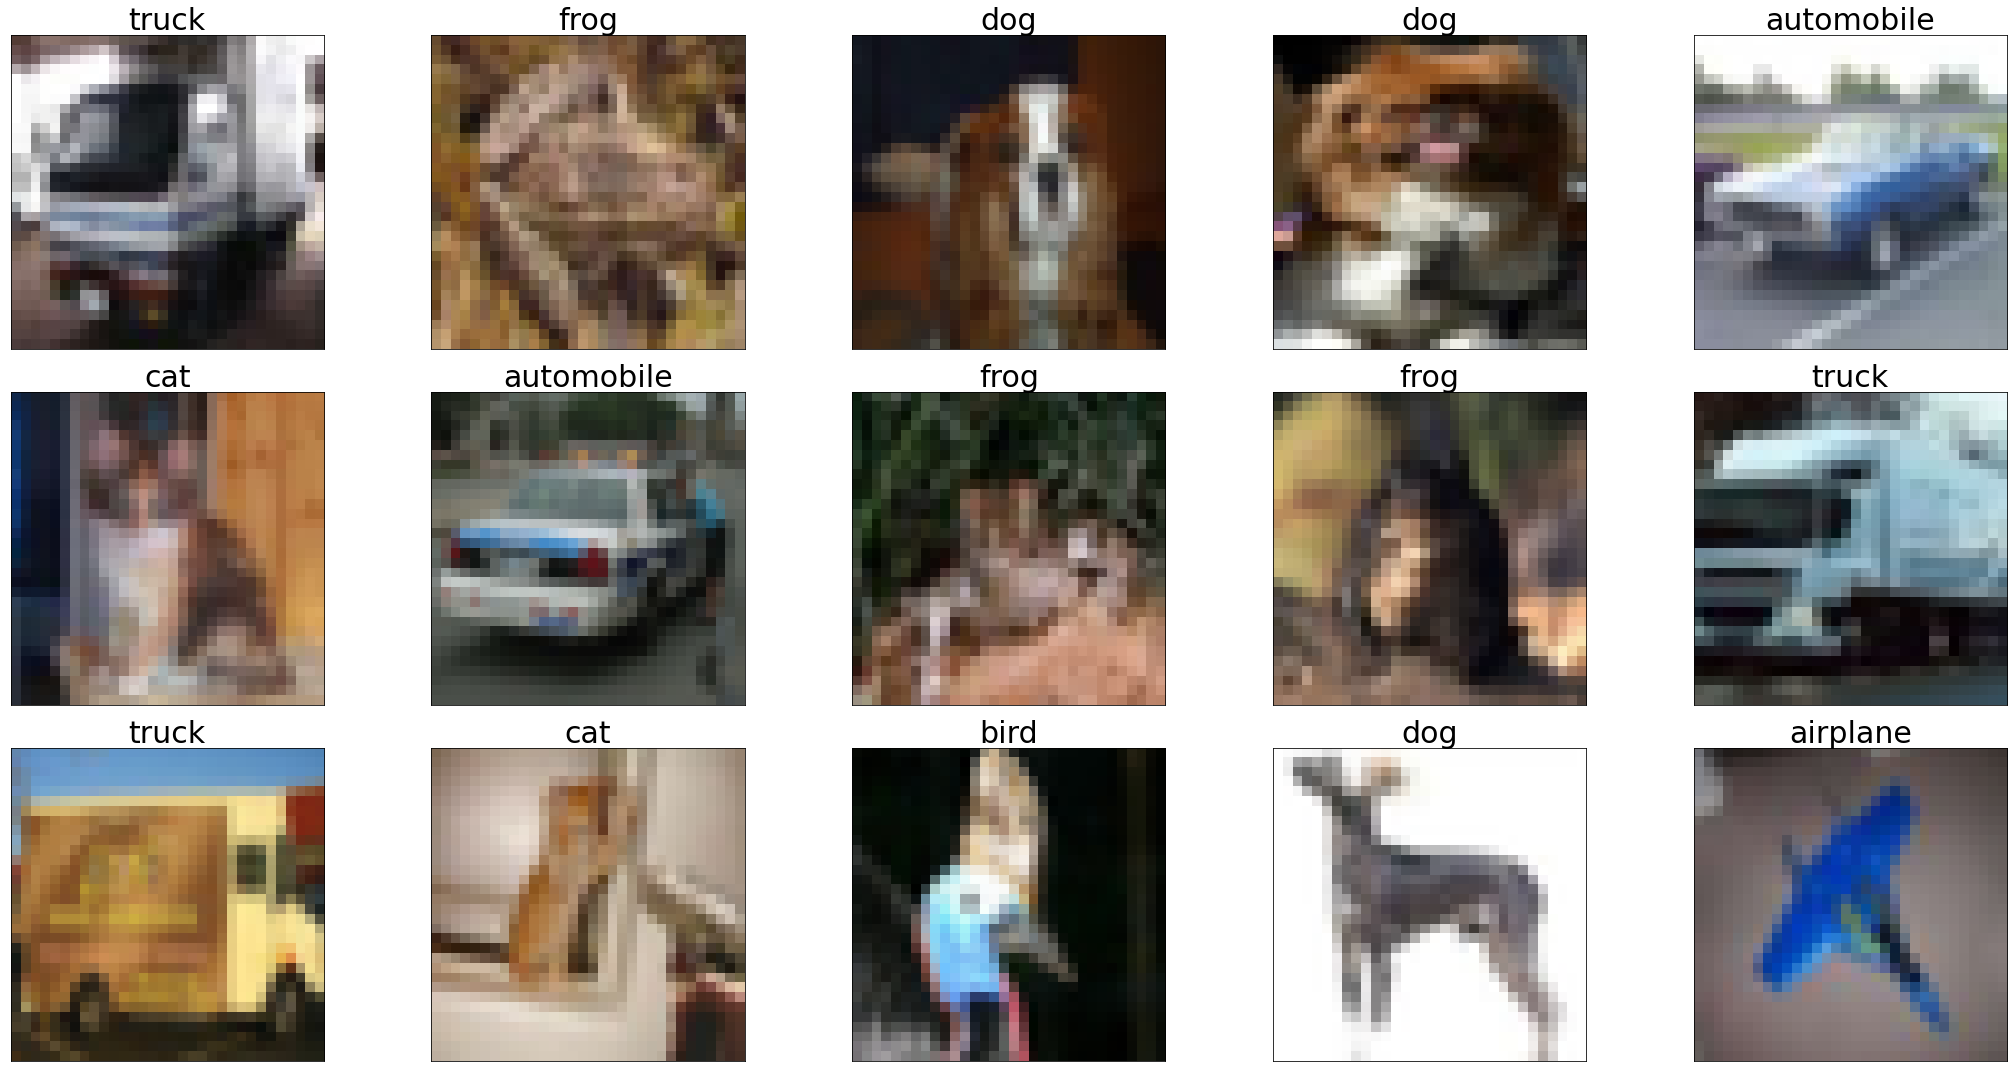

In [ ]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

for x, y in loader:
    break

#wizaulizacja
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class KlasyfikacjaObrazu(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  #predykcja
        loss = F.cross_entropy(out, labels) #obliczenie straty/entropia krzyżowa
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    #predykcja
        loss = F.cross_entropy(out, labels)   #obliczenie straty/entropia
        acc = accuracy(out, labels)           #przewidywanie dokładności
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   #połączenie strat
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      #połączenie dopasowań
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        #zbiór treningowy
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #zbiór walidacyjny
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def to_device(data, device):
    #przeniesienie tensoru do komputera
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #przeniesienie danych, załadowanie ich
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #wywołanie danych
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        #batche
        return len(self.dl)

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [ ]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
batch_size=128 #załadowałam dataset ponownie, żeby od razu określić rozmiar batcha
#określam zbiory treningowe i testowe
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [ ]:
def get_default_device():
    #wybór dostępności procesorów GPU albo CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device #w tym wypadku dobrało CPU

device(type='cpu')

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*32*32 #rozmiar obrazka wgranego
output_size = 10 #rozmiar obrazka wyjściowego

In [ ]:
class CIFAR10Model(KlasyfikacjaObrazu):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 1536)
        self.fc2 = nn.Linear(1536, 768)
        self.fc3 = nn.Linear(768, 384)
        self.fc4 = nn.Linear(384, 128)
        self.fc5 = nn.Linear(128, output_size)
        
    def forward(self, xb):
        #przekształcenie obrazków do wektorów
        out = xb.view(xb.size(0), -1)
        #nałożenie warstw i dodanie funkcji
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        return out

In [ ]:
model = to_device(CIFAR10Model(), device)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3030781745910645, 'val_acc': 0.10271139442920685}]

In [ ]:
history += fit(5, 0.01, model, train_loader, val_loader) #trenuję tylko na 5-ciu epoch, z dopasowaniem 0.01

Epoch [0], val_loss: 2.2944, val_acc: 0.1843
Epoch [1], val_loss: 2.2737, val_acc: 0.1913
Epoch [2], val_loss: 2.1788, val_acc: 0.2111
Epoch [3], val_loss: 2.0646, val_acc: 0.2289
Epoch [4], val_loss: 2.0202, val_acc: 0.2620


In [ ]:
history += fit(5, 0.001, model, train_loader, val_loader) #trenuję na 5-ciu epoch z dopasowaniem 0.001

Epoch [0], val_loss: 2.0126, val_acc: 0.2616
Epoch [1], val_loss: 2.0087, val_acc: 0.2597
Epoch [2], val_loss: 2.0032, val_acc: 0.2635
Epoch [3], val_loss: 1.9980, val_acc: 0.2663
Epoch [4], val_loss: 1.9932, val_acc: 0.2678


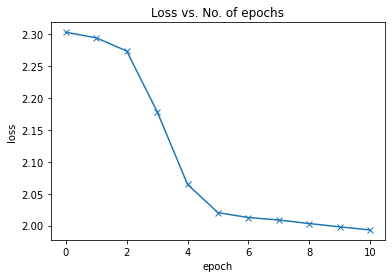

In [ ]:
plot_losses(history) #sprawdzam co się wydarzyło i jaka jest kara za przewidywanie

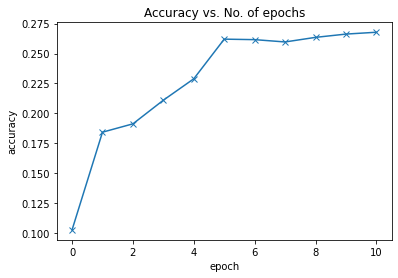

In [ ]:
plot_accuracies(history) #badam jak mi się dopasowało